In [1]:
import pyodbc
import pandas as pd
import numpy as np

In [2]:
conn = pyodbc.connect(
    "Driver={SQL Server};"
    "Server=DESKTOP-7K1D2RJ;"
    "Database=DWH;"
    "Trusted_Connection=yes;"
)

In [3]:
query = "SELECT * FROM FactAchat"
df = pd.read_sql(query, conn)

C:\Users\Ichrak\AppData\Local\Temp\ipykernel_10628\3799946634.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [5]:
query = """
SELECT 
    f.DateFK,
    f.Prix_Unitaire
FROM 
    FactAchat f
"""
# Fetch the data into a DataFrame
df = pd.read_sql(query, conn)

# Close the connection
conn.close()

# Display the data
print(df.head())


C:\Users\Ichrak\AppData\Local\Temp\ipykernel_10628\831543451.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


ProgrammingError: Attempt to use a closed connection.

In [6]:
df.loc[:98, 'DateFK'] = pd.to_datetime(df.loc[:98, 'DateFK'], format='%Y%m%d')


In [7]:
df = df.head(99)


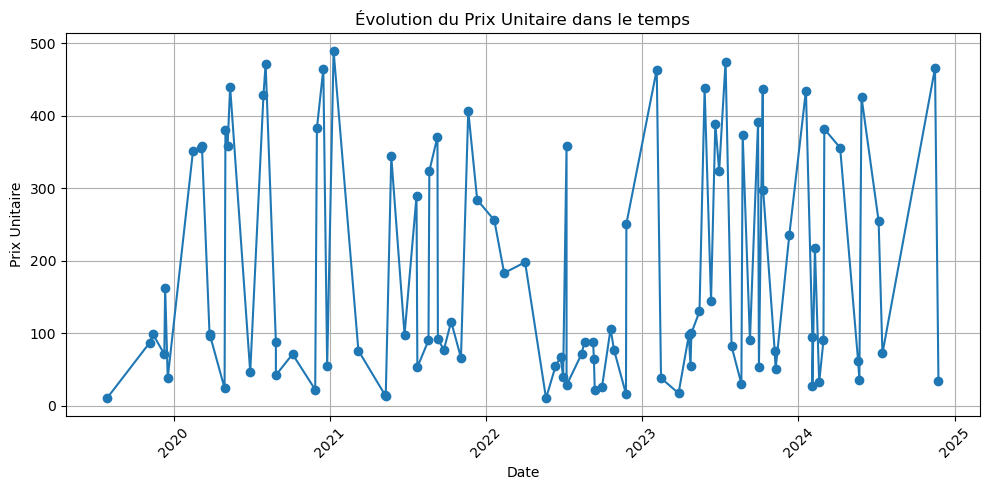

In [8]:
import matplotlib.pyplot as plt

# Assure-toi que DateFK est bien en datetime
df['DateFK'] = pd.to_datetime(df['DateFK'], format='%Y%m%d')

# Tri des dates (important pour les séries temporelles)
df = df.sort_values('DateFK')

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df['DateFK'], df['Prix_Unitaire'], marker='o', linestyle='-')

# Titres et labels
plt.title("Évolution du Prix Unitaire dans le temps")
plt.xlabel("Date")
plt.ylabel("Prix Unitaire")
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [14]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Définir la série à modéliser
serie = df['Prix_Unitaire']

# Créer le modèle ARIMA (ordre (p,d,q), ex : (1,1,1))
model = ARIMA(serie, order=(2,1,1))
model_fit = model.fit()

# Afficher le résumé
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:          Prix_Unitaire   No. Observations:                   99
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -636.724
Date:                Wed, 30 Apr 2025   AIC                           1281.447
Time:                        02:16:39   BIC                           1291.787
Sample:                             0   HQIC                          1285.630
                                 - 99                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0503      0.105      0.481      0.631      -0.155       0.255
ar.L2         -0.0475      0.101     -0.471      0.637      -0.245       0.150
ma.L1         -0.9999     11.632     -0.086      0.9

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [15]:
# Prédire sur la série entière
preds = model_fit.predict(start=0, end=len(serie)-1, typ='levels')




In [16]:
from sklearn.metrics import mean_squared_error
import numpy as np


In [17]:
# Assurer que les longueurs correspondent
rmse = np.sqrt(mean_squared_error(serie, preds))
print(f"RMSE: {rmse:.2f}")


RMSE: 158.98


In [18]:
pip install prophet


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [19]:
from prophet import Prophet

# On crée un nouveau DataFrame au bon format
df_prophet = df[['DateFK', 'Prix_Unitaire']].copy()
df_prophet.columns = ['ds', 'y']


02:16:44 - cmdstanpy - INFO - Chain [1] start processing
02:16:44 - cmdstanpy - INFO - Chain [1] done processing


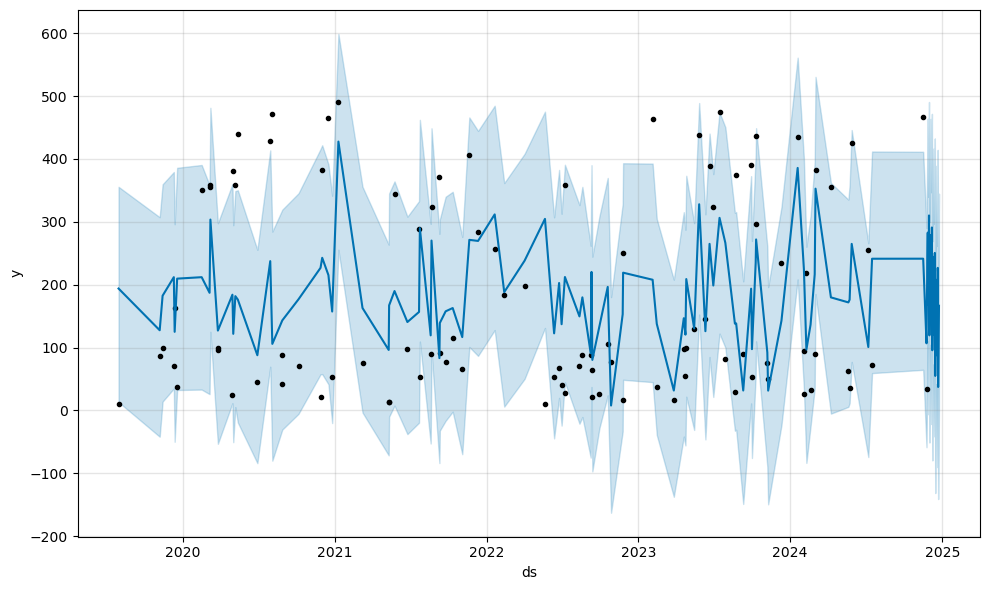

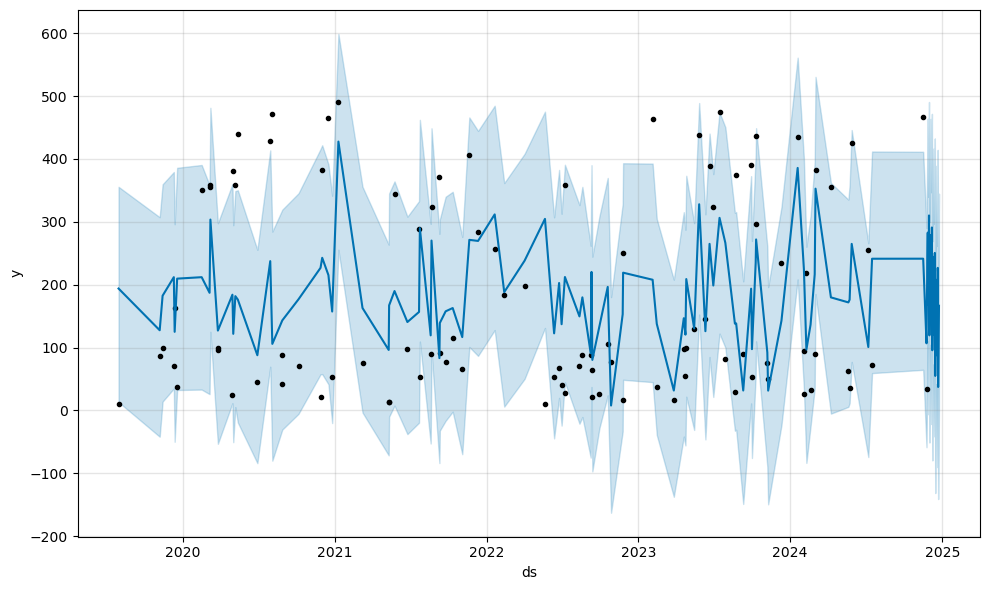

In [20]:
from prophet import Prophet

# Créer un DataFrame formaté pour Prophet
df_prophet = df[['DateFK', 'Prix_Unitaire']].copy()
df_prophet.columns = ['ds', 'y']  # Prophet veut "ds" pour date, "y" pour valeur

# Initialiser le modèle Prophet
model = Prophet()
model.fit(df_prophet)

# Créer les futures dates à prédire
future = model.make_future_dataframe(periods=30)  # ✅ C'est ici que cette méthode fonctionne

# Prédictions
forecast = model.predict(future)

# Visualisation
model.plot(forecast)


In [24]:
# Aligner les longueurs (même index/date)
y_true = df_prophet['y']
y_pred = forecast['yhat'].iloc[:len(y_true)]

# Calcul de la RMSE
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE (Prophet): {rmse:.2f}")


RMSE (Prophet): 177.94


In [25]:
import pickle


In [26]:
with open('arima_model.pkl', 'wb') as file:
    pickle.dump(model_fit, file)
